In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

sys.path.append('../..')

from batchflow import Dataset, DatasetIndex, Pipeline, B, V
from batchflow.models.torch import UNet
from batchflow.models.torch.utils import get_shape

In [3]:
base = np.random.rand(1000, 100)
base = np.expand_dims(np.sin(base * 2 * np.pi), axis=-1)
base = np.tile(base, 15) + np.random.rand(15) * 10
base = base ** 2
base = base.transpose((0, 2, 1))
base += np.random.randn(*base.shape)

In [4]:
def dataset(base, base_logs=3, random_logs=5):
    n_logs = base.shape[-2]
    x = base.copy()
    y = base.copy()
    print(x.shape)
    for i in range(base.shape[0]):
        indices = [np.arange(base_logs), np.arange(base_logs, n_logs)]
        indices[1] = np.random.choice(indices[1], np.random.randint(0, random_logs), replace=False)
        indices = np.sort(np.concatenate(indices))
        additional_indices = np.sort(list(set(np.arange(n_logs)) - set(indices)))
        x[i, additional_indices] = np.nan
    masks = (np.isnan(x).sum(axis=-1) > 0).astype('int')
    x[np.isnan(x)] = 0
    return x, y, masks

In [5]:
x, y, masks = dataset(base, 0, 10)

(1000, 15, 100)


In [6]:
ds = Dataset(index=np.arange(len(x)))
ds.split()

In [33]:
model_config = {
    'device': 'cuda:0',
    'initial_block/inputs': ('x', 'masks'),
    'inputs/x': {'shape': [15, 100]},
    'inputs/y': {'shape': [15, 100]},
    'inputs/masks': {'shape': (15, )},
    "head/num_classes": 15,
    'loss': ('mse', {'reduction': 'sum'})
}

In [34]:
class InitialBlock(nn.Module):
    def __init__(self, input_shapes):
        super().__init__()
        n_channels = input_shapes[0][1]
        # self.a = nn.Parameter(torch.tensor([1.] * n_channels, requires_grad=True))
        self.b = nn.Parameter(torch.tensor([1.] * n_channels, requires_grad=True))
        self.output_shape = input_shapes[0]

    def forward(self, inputs):
        x, masks = inputs
        A = x#  * self.a[..., np.newaxis]
        B = masks * self.b
        return A + B[..., np.newaxis]

In [35]:
class LogUNet(UNet):
    def initial_block(self, inputs, *args, **kwargs):
        return InitialBlock(inputs)
    def body(self, *args, **kwargs):
        return super().body(*args, **kwargs)
    
    def train(self, inputs, targets, fetches=None, use_lock=False):    # pylint: disable=arguments-differ
        """ Train the model with the data provided
        """
        if use_lock:
            self._train_lock.acquire()

        inputs, targets = self._fill_input(inputs, targets)
        
        self.model.train()

        if self.lr_decay:
            self.lr_decay()
        self.optimizer.zero_grad()

        self.predictions = self.model(inputs)
        self.loss = self.loss_fn(self.predictions, targets) / inputs[1].sum()

        self.loss.backward()
        self.optimizer.step()

        if use_lock:
            self._train_lock.release()

        config = self.build_config()
        self.output(inputs=self.predictions, predictions=config['predictions'],
                    ops=config['output'], **config['common'])
        output = self._fill_output(fetches)

        return output

In [36]:
train_ppl = (ds.train.p
             .load(src=x.astype('float32'), components='x')
             .load(src=y.astype('float32'), components='y')
             .load(src=masks.astype('float32'), components='masks')
             .init_variable('loss', init_on_each_run=list)
             .init_variable('output', init_on_each_run=list)
             .init_model('dynamic', LogUNet, 'model', model_config)
             .train_model('model', (B('x'), B('masks')), B('y'), fetches='loss',
                          save_to=V('loss'), mode='a')
            )

In [37]:
train_ppl.run(32, n_epochs=100, shuffle=True, bar=True)

100%|█████████▉| 2499/2500 [01:26<00:00, 27.49it/s]


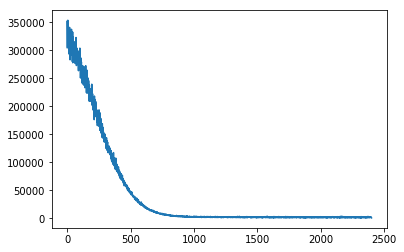

In [38]:
plt.plot(train_ppl.get_variable('loss')[100:])
plt.show()

In [39]:
test_ppl = (ds.test.p
             .load(src=x.astype('float32'), components='x')
             .load(src=y.astype('float32'), components='y')
             .load(src=masks.astype('float32'), components='masks')
             .init_variable('loss', init_on_each_run=list)
             .init_variable('output')
             .import_model('model', train_ppl)
             .predict_model('model', (B('x'), B('masks')), B('y'), fetches='predictions',
                          save_to=V('output'), mode='e')
            )

batch = test_ppl.next_batch(10)

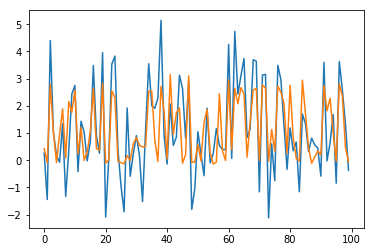

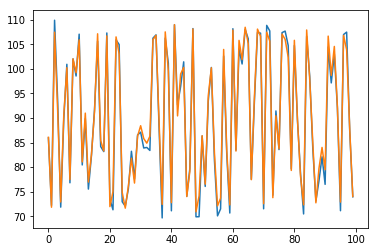

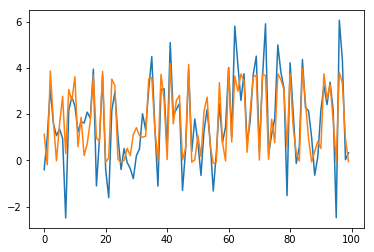

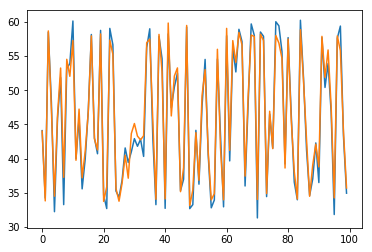

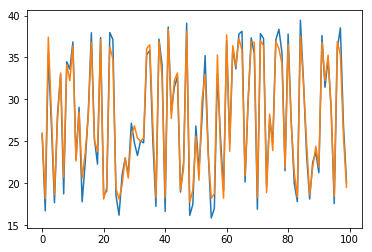

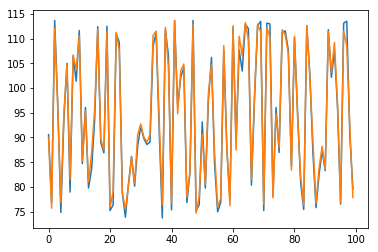

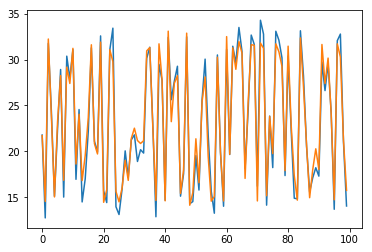

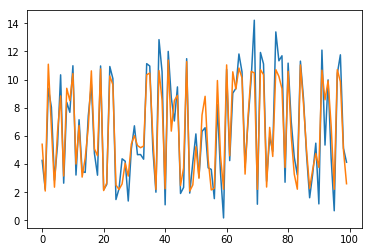

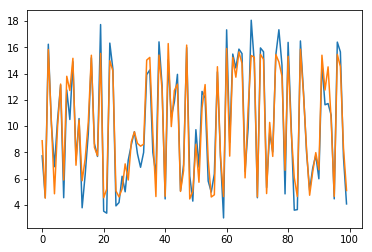

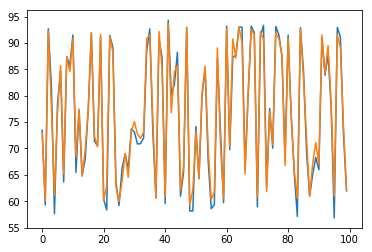

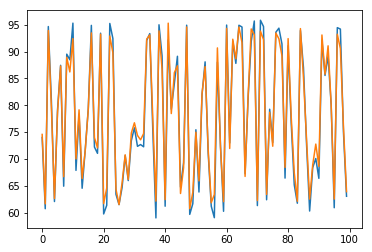

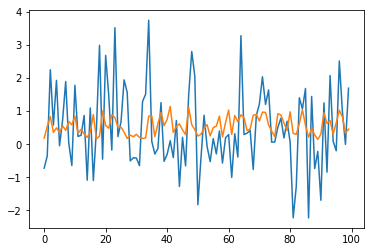

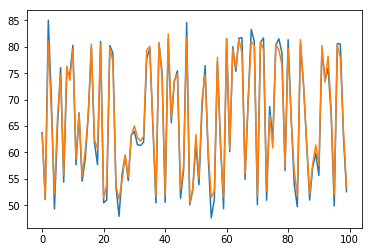

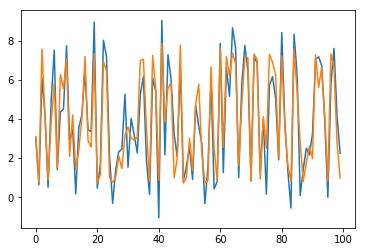

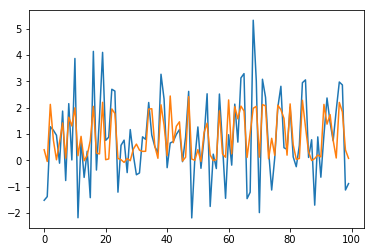

In [40]:
i = 1
for channel in np.arange(15):
    target = batch.y[i, channel]
    prediction = test_ppl.get_variable('output')[i, channel]

    plt.plot(target)
    plt.plot(prediction)
    plt.show()